# Variable TR Height in EBTEL
Test implemention Steve's variable transition height method in EBTEL 

In [1]:
import subprocess
import os

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.interfaces.ebtel import EbtelInterface,RandomNanoflares
from synthesizAR.util import read_xml

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Extrapolate Field and Trace Fieldlines

In [2]:
shape = [ 100, 100] * u.pixel
obs = SkyCoord(lon=0.*u.deg,lat=0.*u.deg,radius=const.au,frame=HeliographicStonyhurst)
blc = SkyCoord(-50 * u.arcsec, -50 * u.arcsec,frame=Helioprojective(observer=obs))
trc = SkyCoord(50 * u.arcsec, 50 * u.arcsec, frame=Helioprojective(observer=obs))
centers = SkyCoord([15, -15,]*u.arcsec,[0, 0,]*u.arcsec,frame=Helioprojective(observer=obs))
sigmas = u.Quantity([[5, 5], [5, 5],],'arcsec')
amplitudes = u.Quantity([1e3, -1e3,], 'Gauss')

In [3]:
magnetogram = synthesizAR.extrapolate.synthetic_magnetogram(blc, trc, shape, centers, sigmas, amplitudes, observer=obs)

In [4]:
shape_z = 100 * u.pixel
width_z = (magnetogram.scale.axis1 * shape_z).to(u.radian).value * magnetogram.dsun

In [5]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram, width_z, shape_z)
B_field = extrapolator.extrapolate()

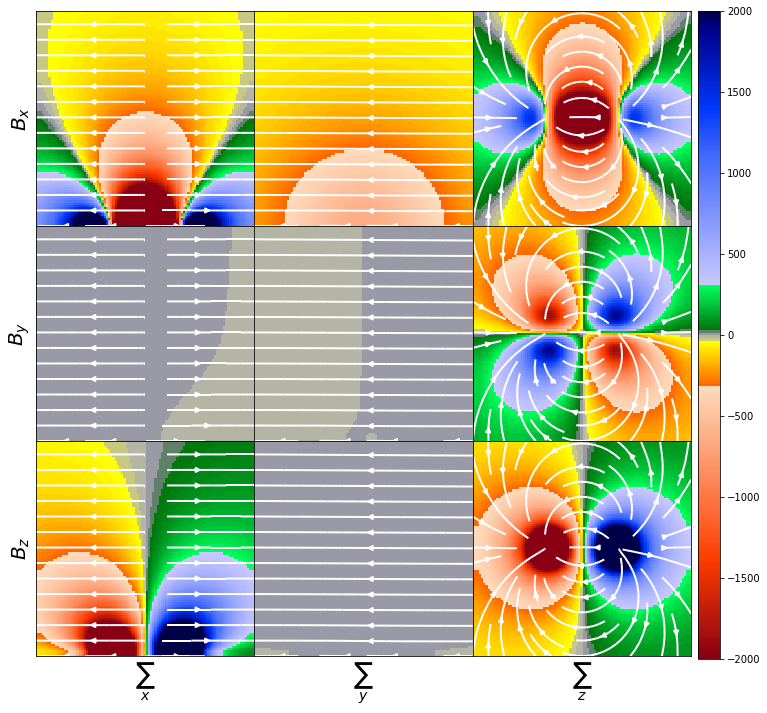

In [6]:
synthesizAR.extrapolate.peek_projections(B_field)

In [10]:
fieldlines = extrapolator.trace_fieldlines(B_field, 250, mask_threshold=0.25)

yt : [INFO     ] 2018-06-10 00:38:26,851 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-06-10 00:38:26,852 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-06-10 00:38:26,854 Parameters: domain_left_edge          = [-3.60943875e+09 -3.60943778e+09  0.00000000e+00]
yt : [INFO     ] 2018-06-10 00:38:26,861 Parameters: domain_right_edge         = [3.60963607e+09 3.60963510e+09 7.25270944e+09]
yt : [INFO     ] 2018-06-10 00:38:26,866 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-06-10 00:38:27,357 AMRKDTree rebuilt, Final Volume: 3.779751e+29
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 365.42it/s]
yt : [INFO     ] 2018-06-10 00:38:28,441 AMRKDTree rebuilt, Final Volume: 3.779751e+29
Streamlining: 100%|██████████| 140/140 [00:00<00:00, 372.01it/s]
yt : [INFO     ] 2018-06-10 00:38:29,201 AMRKDTree rebuilt, Final Volume: 3.779751e+29
Streamlining: 100%|██████████| 77/77 [00:00<00:00, 406.91it/s]
yt : [INFO     ] 2018-

FloatProgress(value=0.0)

In [11]:
active_region = synthesizAR.Field(magnetogram, fieldlines)

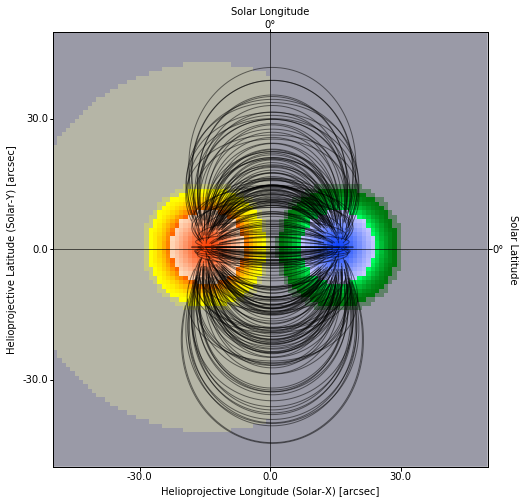

In [12]:
active_region.peek(line_frequency=1)

In [156]:
active_region.save('/Users/willbarnes/Desktop/varying_tr_height/field_checkpoint')

In [2]:
active_region = synthesizAR.Field.restore('/Users/willbarnes/Desktop/varying_tr_height/field_checkpoint')

## Modified EBTEL Interface to include Variable TR Height

In [64]:
def get_tr_height(L,T,n,v):
    # Constants
    c1,c2,c3 = 0.6,0.9,4.0
    kappa_0 = 1e-6
    chi = 10**(-18.66)
    alpha = -0.5
    m_i = const.m_p.to(u.g).value
    # Calculate TR height
    a = kappa_0 * (T**(3.5)) * (1-c1)/c2
    b = m_i * n * (v**3) * (c2/2*(1 - 1/c1) - c1/c2)
    c = -c3*(n**2)*chi*(T**alpha)
    l_c_vgt0 = np.sqrt(-a / c)
    l_c_vlt0 = 2*a / (-b + np.sqrt(b**2 - 4*a*c))
    l_c = l_c_vlt0#np.where(v >= 0, l_c_vgt0, l_c_vlt0)
    l_c_max = L - L*0.05
    l_c = np.where(l_c > l_c_max, l_c_max, l_c)
    l_tr = L - l_c
    return l_tr,l_c

In [62]:
class EBTELVaryingTRHeightInterface(EbtelInterface):
    
    def load_results(self,loop):
        t,Te,Ti,n,v = super().load_results(loop)
        # Constants
        c1,c2,c3 = 0.6,0.9,4.0
        alpha = -0.5
        # Calculate TR quantities
        T_tr = c1 / (2.*c2) * Te
        n_tr = n * np.sqrt(c3) * (2.*c2/c1)**(alpha/2.)
        # Calculate TR height
        return t,Te,Ti,n,v

In [52]:
base_config = read_xml('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 1e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0
base_config['surface_gravity'] = 1.

In [14]:
class CoherentNanoflares(object):
    @u.quantity_input
    def __init__(self, duration: u.s, stress):
        self.duration = duration.to(u.s).value
        self.stress = stress
        
    def calculate_event_properties(self, loop):
        self.number_events = 1
        start_time = 0.
        max_energy = (self.stress * loop.field_strength.mean().value)**2/(8.*np.pi)
        return {'magnitude': np.array([max_energy/(self.duration/2.)]),
                'rise_start': np.array([start_time]),
                'rise_end': np.array([start_time+self.duration/2]),
                'decay_start': np.array([start_time+self.duration/2]),
                'decay_end': np.array([start_time+self.duration])}

In [15]:
heating_model = CoherentNanoflares(200*u.s,0.3)

In [58]:
ebtel = EBTELVaryingTRHeightInterface(base_config,heating_model,
                                      '/Users/willbarnes/Desktop/varying_tr_height/hydro_config',
                                      '/Users/willbarnes/Desktop/varying_tr_height/hydro_results')

In [17]:
active_region.configure_loop_simulations(ebtel)

FloatProgress(value=0.0)

In [18]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [19]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [46]:
for l in active_region.loops:
    print(f'name: {l.name}, $2L={l.full_length.to(u.Mm)}$')

name: loop000000, $2L=21.896342882281605 Mm$
name: loop000001, $2L=34.10305044079765 Mm$
name: loop000002, $2L=40.20669685909988 Mm$
name: loop000003, $2L=65.69991494716344 Mm$
name: loop000004, $2L=22.255036828303446 Mm$
name: loop000005, $2L=47.38830889218929 Mm$
name: loop000006, $2L=24.050362573275457 Mm$
name: loop000007, $2L=28.358202126567406 Mm$
name: loop000008, $2L=37.69373092252262 Mm$
name: loop000009, $2L=57.44127192696579 Mm$
name: loop000010, $2L=44.156243031309444 Mm$
name: loop000011, $2L=24.05044787915658 Mm$
name: loop000012, $2L=23.69144923362757 Mm$
name: loop000013, $2L=24.05040241305966 Mm$
name: loop000014, $2L=24.050261337642805 Mm$
name: loop000015, $2L=60.31428425964267 Mm$
name: loop000016, $2L=56.7231217477492 Mm$
name: loop000017, $2L=22.254788461309165 Mm$
name: loop000018, $2L=22.254907397037886 Mm$
name: loop000019, $2L=33.74378911520621 Mm$
name: loop000020, $2L=22.254965684353973 Mm$
name: loop000021, $2L=24.05014120651849 Mm$
name: loop000022, $2L=22

In [59]:
loop_select = active_region.loops[2]

In [60]:
t,Te,Ti,n,v,l_c,l_tr = ebtel.load_results(loop_select)

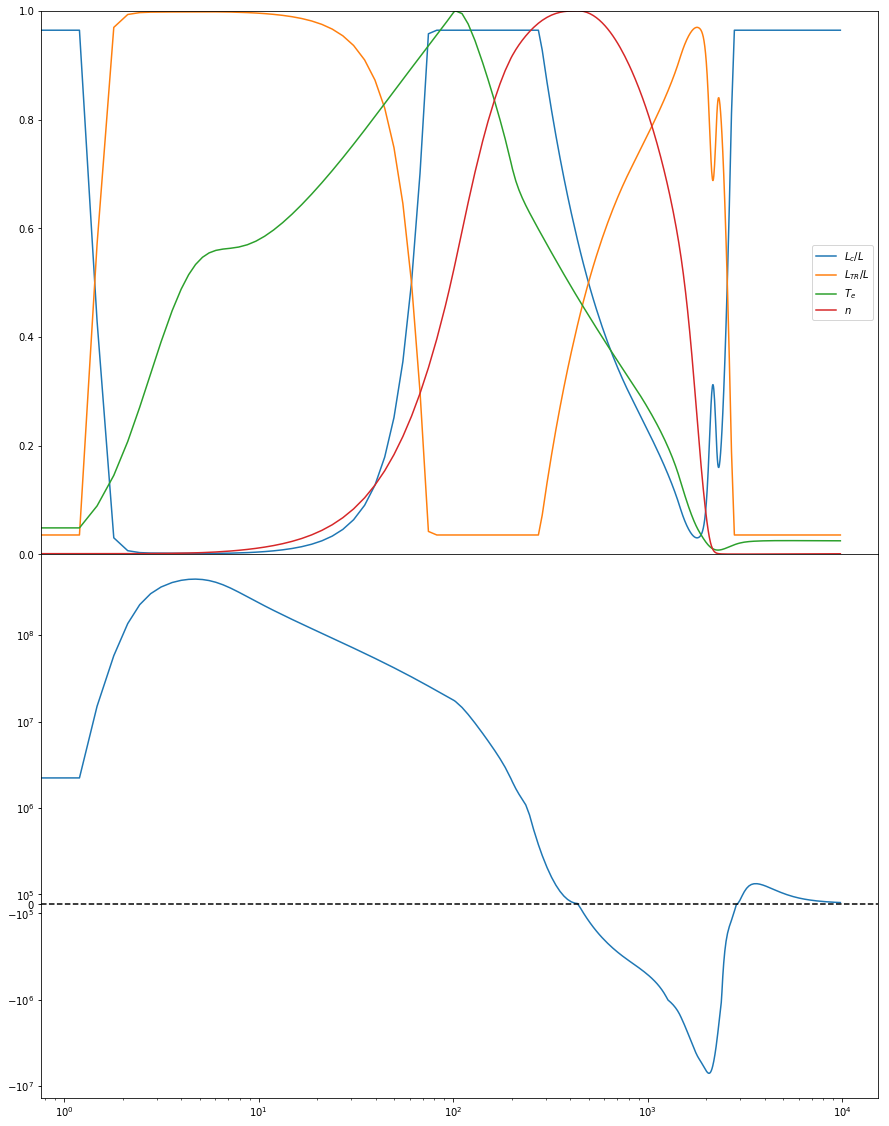

In [61]:
plt.figure(figsize=(15,20))
plt.subplot(211)
plt.plot(t,l_c/loop_select.full_length*2.,label=r'$L_c/L$')
plt.plot(t,l_tr/loop_select.full_length*2.,label=r'$L_{TR}/L$')
#plt.plot((l_c + l_tr)/loop_select.full_length*2)
plt.plot(t,(Te/Te.max())[:,0],label='$T_e$')
plt.plot(t,(n/n.max())[:,0],label='$n$')
plt.ylim(0,1);
#plt.xlim(0,1.8e3)
plt.legend();
plt.xscale('log')
plt.subplot(212)
plt.plot(t,v[:,0])
plt.axhline(y=0,ls='--',color='k')
plt.yscale('symlog',linthreshy=1e6)
plt.xscale('log')
plt.subplots_adjust(hspace=0)

In [83]:
l_tr / (active_region.loops[0].full_length/2.)

<Quantity [1.06558229, 1.06558229, 1.54291979, 1.93758596, 1.97606173,
           1.98016563, 1.97870761, 1.97508014, 1.9712203 , 1.96896934,
           1.96737671, 1.96646737, 1.96642112, 1.9673358 , 1.96919251,
           1.9718216 , 1.97451471, 1.97692103, 1.97898885, 1.98068037,
           1.98197392, 1.98288383, 1.98337907, 1.98322345, 1.98207511,
           1.97947201, 1.97526825, 1.96937528, 1.96147767, 1.95109222,
           1.93746136, 1.91950104, 1.89563249, 1.86359267, 1.8201855 ,
           1.76085887, 1.67903119, 1.56497602, 1.40683646, 1.20329534,
           1.06558229, 1.06558229, 1.06558229, 1.06558229, 1.06558229,
           1.06558229, 1.06558229, 1.06558229, 1.06558229, 1.06558229,
           1.06558229, 1.06558229, 1.06558229, 1.06558229, 1.06558229,
           1.06558229, 1.06558229, 1.06558229, 1.06558229, 1.06558229,
           1.06558229, 1.06558229, 1.06558229, 1.06558229, 1.06558229,
           1.06558229, 1.06558229, 1.06558229, 1.06558229, 1.06558229,
      